In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd
import sys
import os


# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [2]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1870, 2024)

pdo['time'] = sst['time']

nino_34 = pdo_functions.oni_moving_base(sst)

In [3]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()

In [4]:
# Calculating when El Nino or La Nina events occur (i.e. when ONI exceeds 0.5 for at least 5 consecutive months)
nino_34_calc = np.zeros((1668))
for i in range(1668):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

In [5]:
# convert nino_34_calc to xr
nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':nino_34_rolling['time']}, dims=['time'])

# 1940-2024 only
nino_34_1940_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [6]:
# Selecting the PDO index only for MAM during 1940-2024'
pdo_1940_2024 = pdo.sel(time=pdo.time.dt.year.isin(np.arange(1940, 2025, 1)))
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

In [7]:
# Need to calculate when El Nino/La Nina Occurs in a given year
nino_34_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) > 0:
        nino_34_1940_2024_mam_ann[i] = 1

    elif nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) < 0:
        nino_34_1940_2024_mam_ann[i] = -1

    else:
        continue

In [8]:
# Open NDSEV data
ndsev_diff = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/ndsev_1940-2024_mam_corrected.nc')['__xarray_dataarray_variable__'].load()

In [9]:
# creating land masks
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
land = xr.where(land_110.mask_3D(ndsev_diff)==True, 1, np.nan).squeeze()
# east_land = xr.where(land_110.mask_3D(ndsev_diff_east)==True, 1, np.nan).squeeze()
# se_land = xr.where(land_110.mask_3D(ndsev_diff_se)==True, 1, np.nan).squeeze()

In [10]:
# Seasonal NDSEV counts
ndsev_diff_count = np.zeros((85, 101, 237))
for i in range(85):
    ndsev_diff_count[i] = (ndsev_diff.transpose('time', 'latitude', 'longitude')[i*92:(i+1)*92]).values.sum(axis=0)

In [11]:
ndsev_diff_count_xr = xr.DataArray(ndsev_diff_count, coords={'time':pdo_1940_2024_mam['time'], 'latitude':ndsev_diff['latitude'], 'longitude':ndsev_diff['longitude']}, dims=['time', 'latitude', 'longitude'])

In [12]:
ndsev_diff_count_de = pdo_functions.detrend_dim(ndsev_diff_count_xr, 'time', 2)

In [13]:
ndsev_diff_count_de

<xarray.DataArray (time: 85, latitude: 101, longitude: 237)> Size: 16MB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -8.57754281e-03, -8.57754281e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -8.57754281e-03],
        [-1.19979345e-03,  0.00000000e+00,  0.00000000e+00, ...,
         -8.57754281e-03, -8.57754281e-03, -2.31036361e-02],
        ...,
        [-7.89065782e-02, -6.15027324e-02, -6.15027324e-02, ...,
          6.54286316e+00,  6.53273515e+00,  5.41280719e+00],
        [-7.89065782e-02, -7.89065782e-02, -8.52026015e-02, ...,
          6.64244565e+00,  7.32574489e+00,  4.96082793e+00],
        [-9.63104241e-02, -8.52026015e-02, -1.02606447e-01, ...,
          6.30364385e+00,  5.51076927e+00,  6.27281601e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -9.43003559e-03, -9.43003559e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -9.43003559e-03],
        [-7.82100605e-04,  0.00000000e+00,  0.00000000e+00, ...,
         -9.43003559e-03, -9.43003559e-03, -2.07708507e-02],
...
        [-1.24145629e-02,  1.34376897e-03,  1.34376897e-03, ...,
          4.83093852e+00,  3.10188687e+00,  3.45954619e+00],
        [-1.24145629e-02, -1.24145629e-02,  4.35092185e-03, ...,
          2.16639184e+00,  3.49251533e+00,  1.69832954e+00],
        [-2.61728947e-02,  4.35092185e-03, -9.40741000e-03, ...,
          1.91788394e+00,  2.01900819e+00,  1.21873845e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.76907648e-02,  1.76907648e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  1.76907648e-02],
        [-5.04511075e-02,  0.00000000e+00,  0.00000000e+00, ...,
          1.76907648e-02,  1.76907648e-02, -8.71322648e-02],
        ...,
        [-1.32450532e-02,  2.52291601e-03,  2.52291601e-03, ...,
         -4.10409924e+00, -1.81511205e+00, -2.44253656e+00],
        [-1.32450532e-02, -1.32450532e-02,  5.08697270e-03, ...,
         -1.78264830e+00, -2.44074948e+00, -2.24260765e+00],
        [-2.90130224e-02,  5.08697270e-03, -1.06809965e-02, ...,
         -2.07036971e+00, -9.27452253e-01, -7.13654094e-01]]])
Coordinates:
  * time       (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
  * latitude   (latitude) float64 808B 49.0 48.75 48.5 48.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float64 2kB 235.0 235.2 235.5 ... 293.5 293.8 294.0

In [14]:
ndsev_pos_pdo = xr.where(pdo_1940_2024_mam > 0, ndsev_diff_count_de, np.nan).dropna(dim='time')

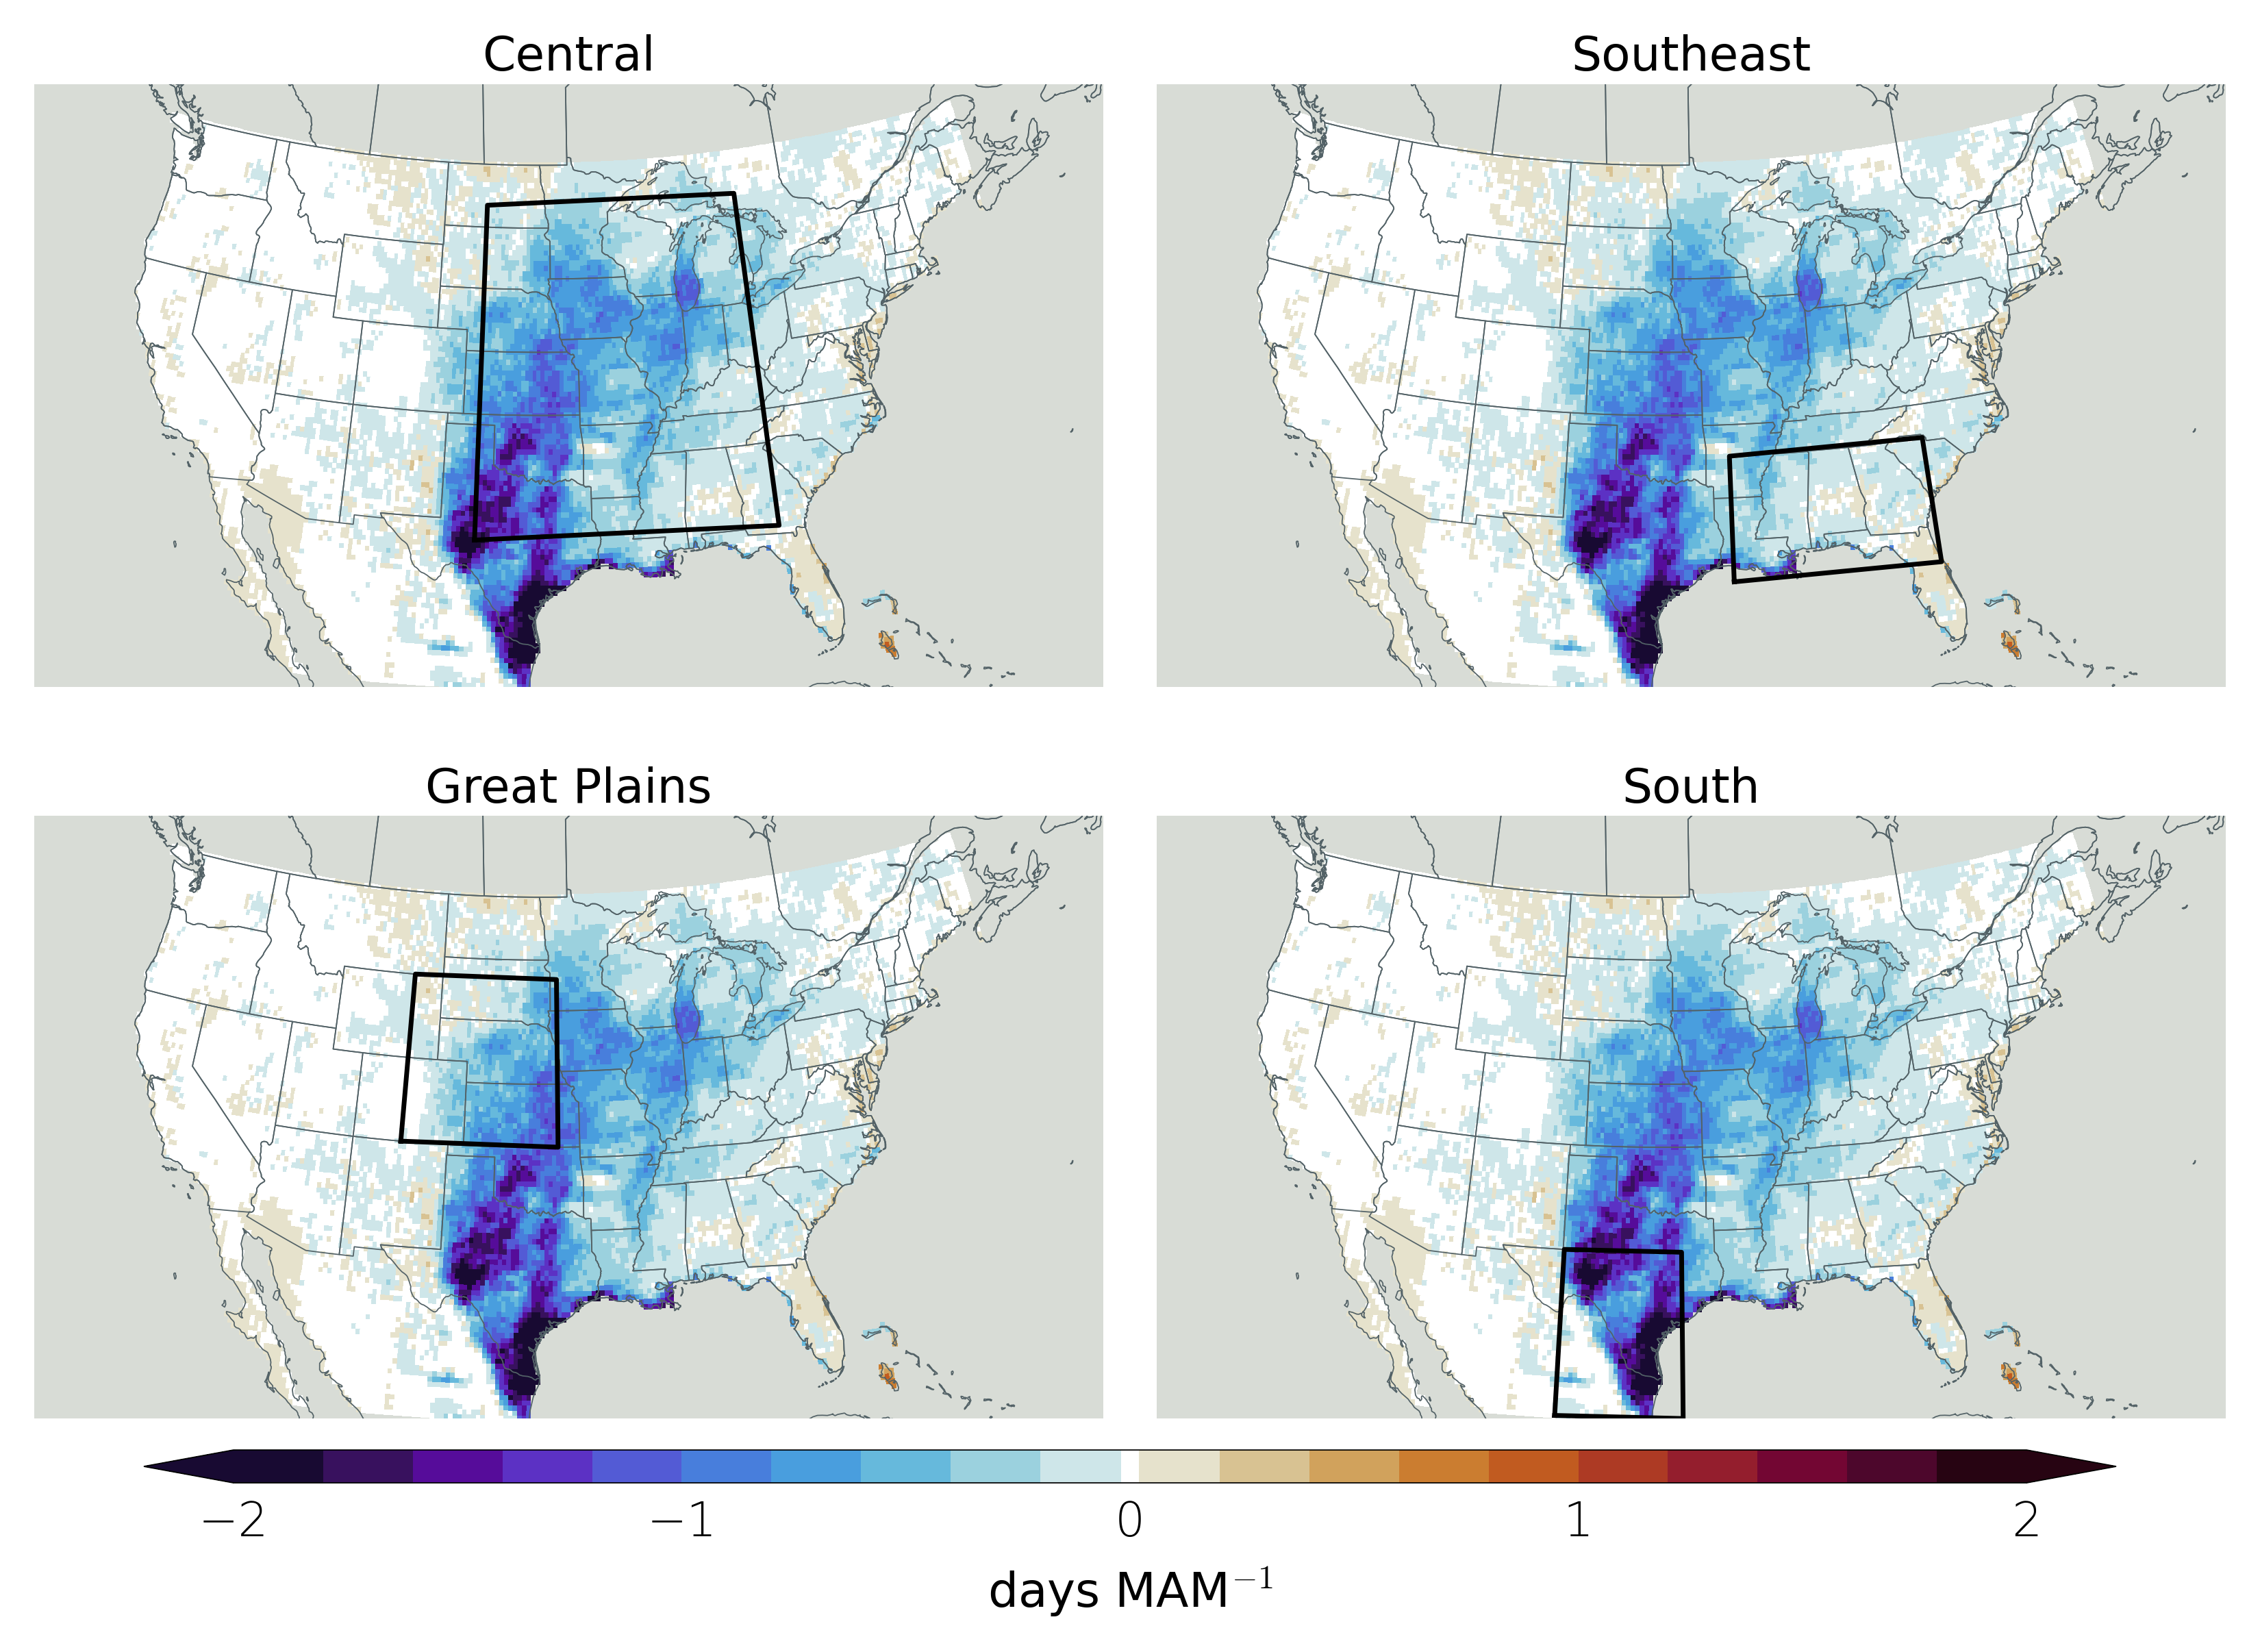

In [15]:
fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], \
      ax[1, 0], ax[1, 1]]

bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.02, 0.02, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(4):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())
    ax[i].pcolormesh(ndsev_diff['longitude'], ndsev_diff['latitude'], ndsev_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), norm=norm, cmap='cmr.fusion_r')
    ax[i].set_facecolor('xkcd:light gray')

lat_min_east, lat_max_east = 31, 47
lon_min_east, lon_max_east = pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83)
rect_lons_east = [lon_min_east, lon_max_east, lon_max_east, lon_min_east, lon_min_east]
rect_lats_east = [lat_min_east, lat_min_east, lat_max_east, lat_max_east, lat_min_east]
ax[0].plot(rect_lons_east, rect_lats_east, color='black', lw=1, transform=ccrs.PlateCarree())

lat_min_se, lat_max_se = 29, 35
lon_min_se, lon_max_se = pdo_functions.convert_longitudes(-93), pdo_functions.convert_longitudes(-81)
rect_lons_se = [lon_min_se, lon_max_se, lon_max_se, lon_min_se, lon_min_se]
rect_lats_se = [lat_min_se, lat_min_se, lat_max_se, lat_max_se, lat_min_se]
ax[1].plot(rect_lons_se, rect_lats_se, color='black', lw=1, transform=ccrs.PlateCarree())

lat_min_central, lat_max_central = 37, 45
lon_min_central, lon_max_central = pdo_functions.convert_longitudes(-106), pdo_functions.convert_longitudes(-96)
rect_lons_central = [lon_min_central, lon_max_central, lon_max_central, lon_min_central, lon_min_central]
rect_lats_central = [lat_min_central, lat_min_central, lat_max_central, lat_max_central, lat_min_central]
ax[2].plot(rect_lons_central, rect_lats_central, color='black', lw=1, transform=ccrs.PlateCarree())

lat_min_south, lat_max_south = 24, 32
lon_min_south, lon_max_south = pdo_functions.convert_longitudes(-103), pdo_functions.convert_longitudes(-96)
rect_lons_south = [lon_min_south, lon_max_south, lon_max_south, lon_min_south, lon_min_south]
rect_lats_south = [lat_min_south, lat_min_south, lat_max_south, lat_max_south, lat_min_south]
ax[3].plot(rect_lons_south, rect_lats_south, color='black', lw=1, transform=ccrs.PlateCarree())

ax[0].set_title('Central', pad=3, fontsize=10)
ax[1].set_title('Southeast', pad=3, fontsize=10)
ax[2].set_title('Great Plains', pad=3, fontsize=10)
ax[3].set_title('South', pad=3, fontsize=10)

cax = plt.axes([0.05, .23, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-2, -1, 0, 1, 2])
cbar.set_label(r'days MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.1, 
                    wspace=0.05, 
                    hspace=0.1)

In [16]:
# Regional subset
ndsev_normal = ndsev_diff_count_de.sel(latitude=slice(47, 30)).sel(longitude=slice(pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82)))
ndsev_se     = ndsev_diff_count_de.sel(latitude=slice(35, 29)).sel(longitude=slice(pdo_functions.convert_longitudes(-93), pdo_functions.convert_longitudes(-81)))
ndsev_central = ndsev_diff_count_de.sel(latitude=slice(45, 37)).sel(longitude=slice(pdo_functions.convert_longitudes(-106), pdo_functions.convert_longitudes(-96)))
ndsev_south   = ndsev_diff_count_de.sel(latitude=slice(32, 24)).sel(longitude=slice(pdo_functions.convert_longitudes(-103), pdo_functions.convert_longitudes(-96)))

In [17]:
# ndsev_normal = ndsev_diff_count_xr.sel(latitude=slice(47, 30)).sel(longitude=slice(pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82)))

In [18]:
# Weight and take spatial mean
weights_normal = np.cos(np.deg2rad(ndsev_normal.latitude))
# weights_se = np.cos(np.deg2rad(ndsev_se.latitude))
# weights_central = np.cos(np.deg2rad(ndsev_central.latitude))
# weights_south = np.cos(np.deg2rad(ndsev_south.latitude))

ndsev_normal_wgt = ndsev_normal.weighted(weights_normal).mean(dim=('latitude', 'longitude'))
# ndsev_se_wgt = ndsev_se.weighted(weights_se).mean(dim=('latitude', 'longitude'))
# ndsev_central_wgt = ndsev_central.weighted(weights_central).mean(dim=('latitude', 'longitude'))
# ndsev_south_wgt = ndsev_south.weighted(weights_south).mean(dim=('latitude', 'longitude'))

In [19]:
# Take 5 year rolling means
ndsev_normal_rolling = ndsev_normal_wgt.rolling(time=5, center=True).mean()
# ndsev_se_rolling = ndsev_se_wgt.rolling(time=5, center=True).mean()
# ndsev_central_rolling = ndsev_central_wgt.rolling(time=5, center=True).mean()
# ndsev_south_rolling = ndsev_south_wgt.rolling(time=5, center=True).mean()

In [20]:
pearson_r, p = scipy.stats.pearsonr(pdo_1940_2024_mam[2:-2], ndsev_normal_rolling[2:-2])

In [21]:
# subset for correlation testing
nino_34_time_per = nino_34_rolling.sel(time=nino_34_rolling.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_time_per_mam = nino_34_time_per.sel(time=nino_34_time_per.time.dt.month.isin([3, 4, 5]))
nino_34_time_per_mam_mean = nino_34_time_per.resample(time='YE').mean()

In [22]:
# Correlation between Nino3.4 and PDO
nino_pearson_r, nino_p = scipy.stats.pearsonr(nino_34_time_per_mam_mean, ndsev_normal_wgt)

In [23]:
nino_pearson_r

-0.4413104524725855

In [24]:
nino_p

2.3621095208493544e-05

In [25]:
ndsev_normal_corr = np.corrcoef(pdo_1940_2024_mam[2:-2], ndsev_normal_rolling[2:-2])[1][0]
# ndsev_se_corr = np.corrcoef(pdo_1940_2024_mam[2:-2], ndsev_se_rolling[2:-2])[1][0]
# ndsev_central_corr = np.corrcoef(pdo_1940_2024_mam[2:-2], ndsev_central_rolling[2:-2])[1][0]
# ndsev_south_corr = np.corrcoef(pdo_1940_2024_mam[2:-2], ndsev_south_rolling[2:-2])[1][0]

In [26]:
ndsev_normal_corr_raw = np.corrcoef(pdo_1940_2024_mam, ndsev_normal_wgt)

In [27]:
# Rolling mean on the PDO
pdo_rolling = pdo_1940_2024_mam.rolling(time=5, center=True).mean()

In [28]:
ndsev_normal_corr_rolling = np.corrcoef(pdo_rolling[2:-2], ndsev_normal_rolling[2:-2])

NameError: name 'ndsev_se_rolling' is not defined

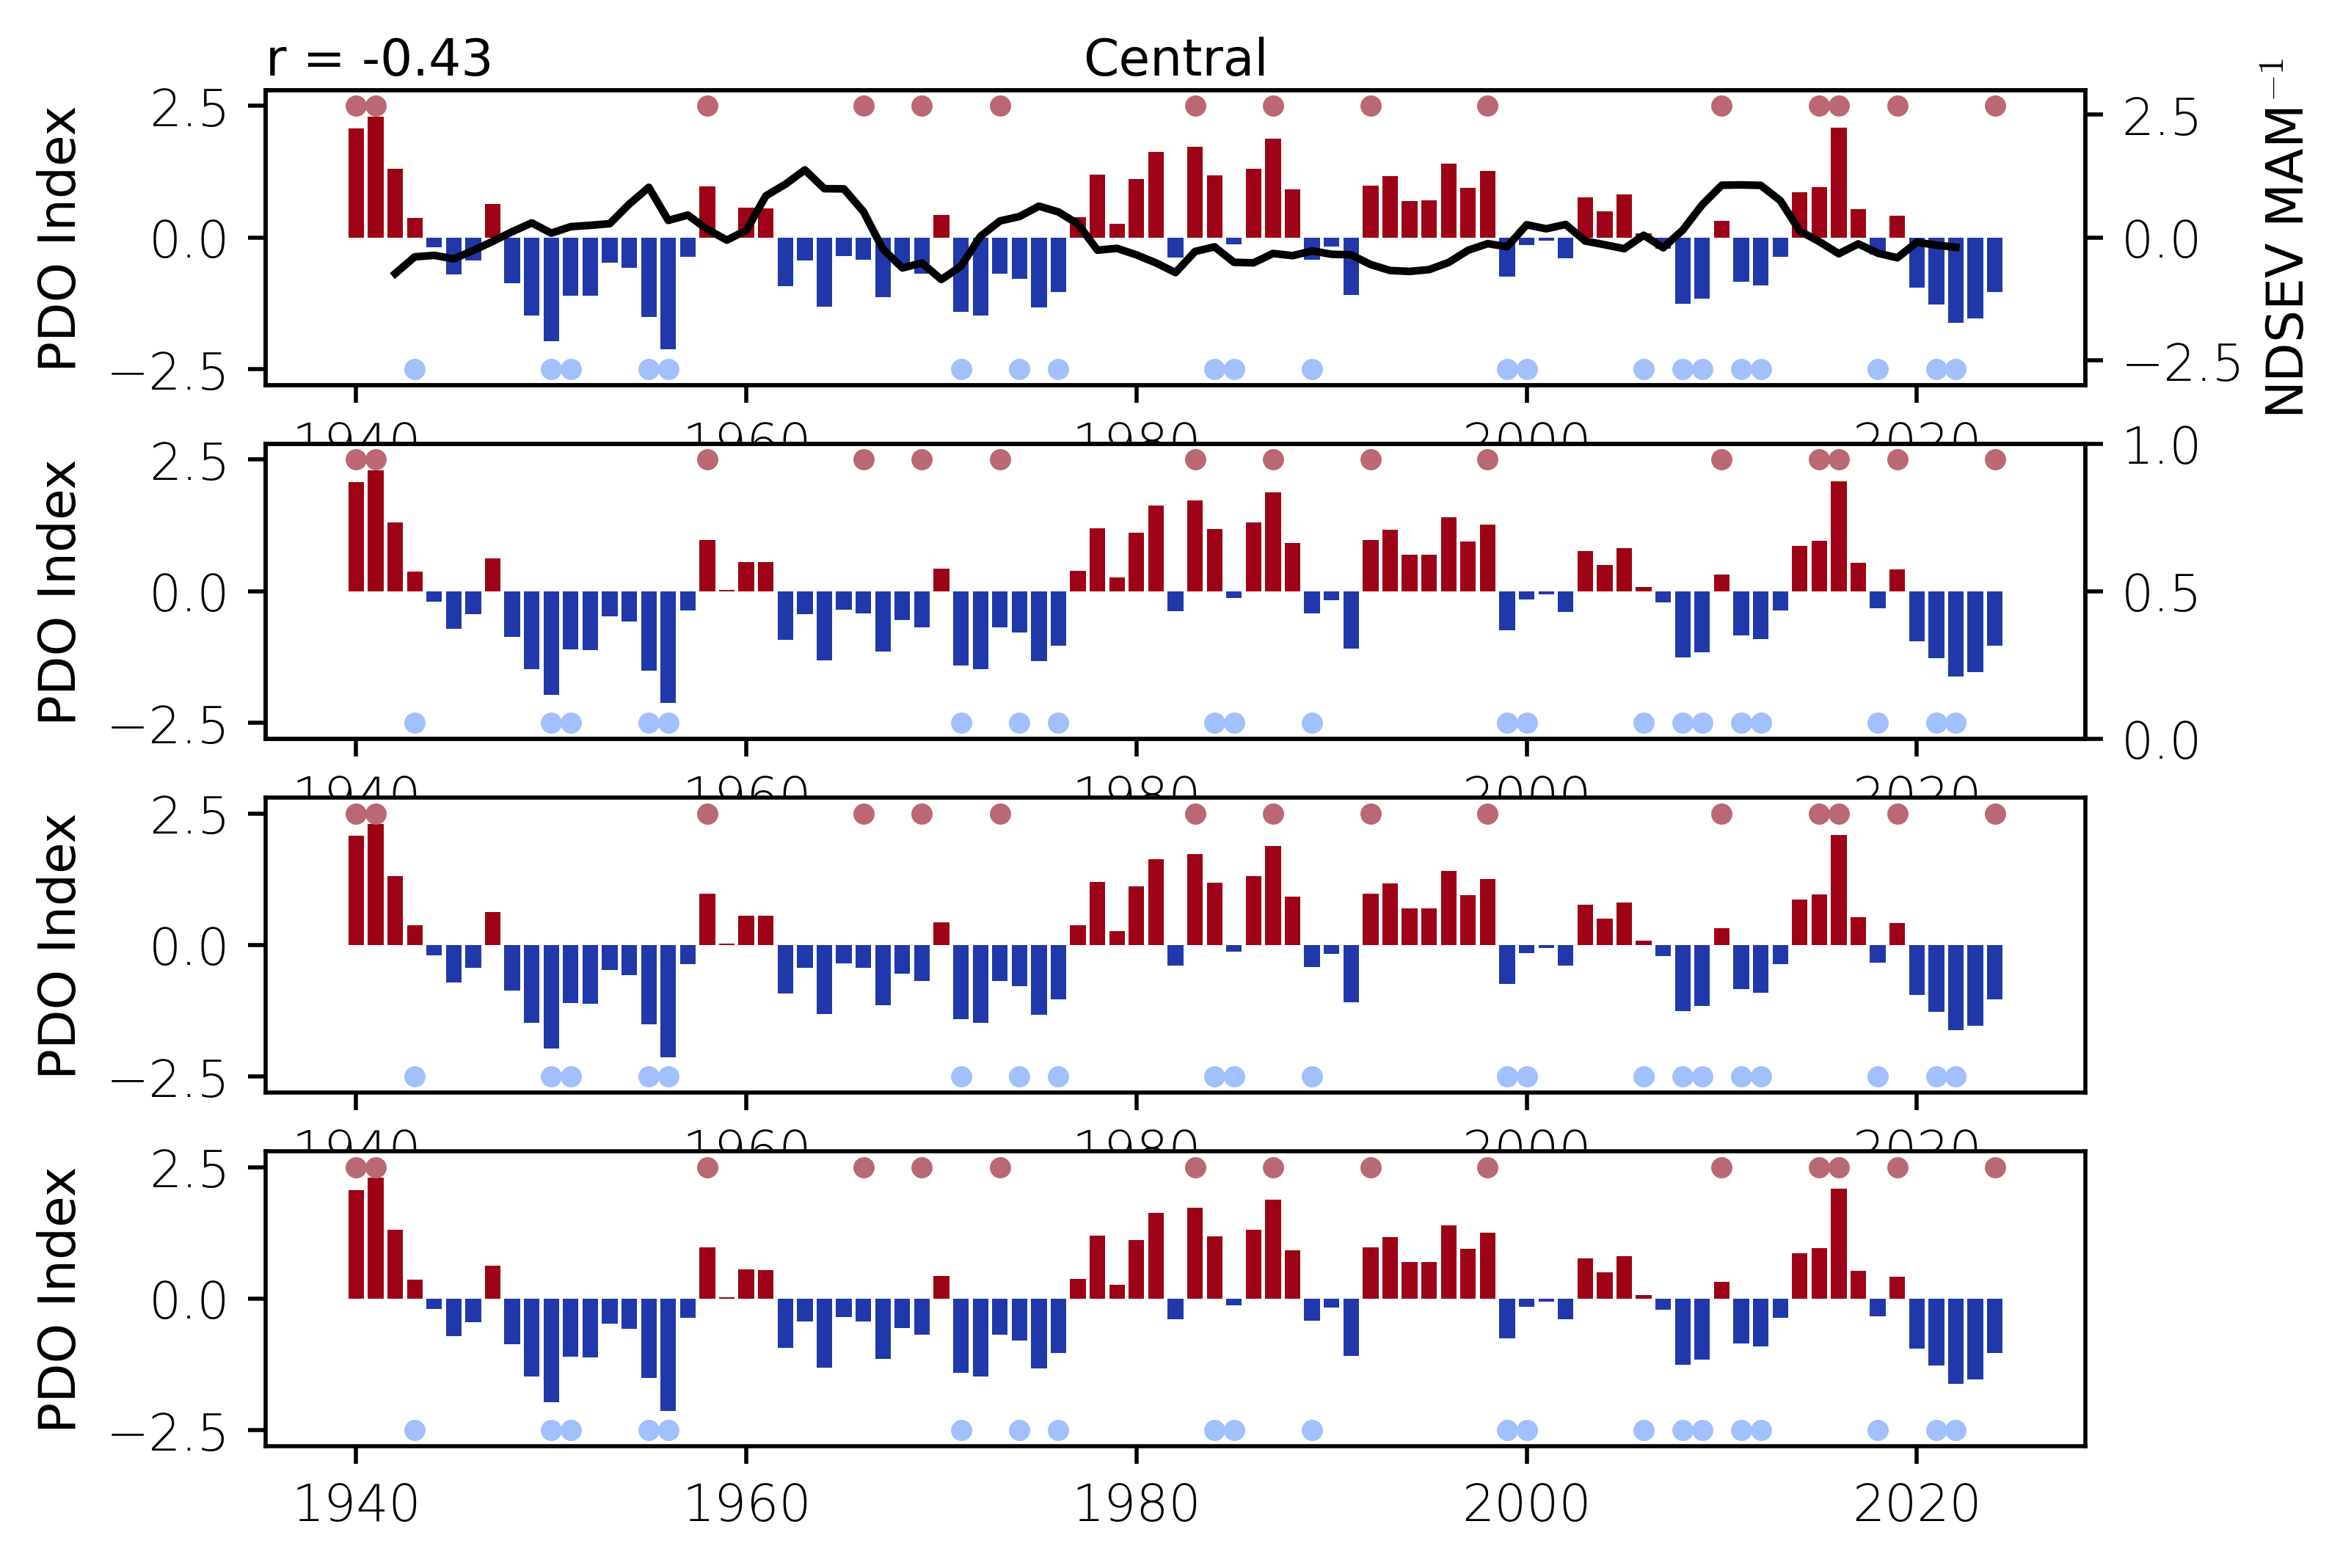

In [29]:
fig, ax = plt.subplots(4, 1)

years = np.arange(1940, 2025, 1)

for i in range(4):
    ax[i].bar(years[pdo_1940_2024_mam > 0], pdo_1940_2024_mam[pdo_1940_2024_mam > 0], color='xkcd:carmine')
    ax[i].bar(years[pdo_1940_2024_mam < 0], pdo_1940_2024_mam[pdo_1940_2024_mam < 0], color='xkcd:sapphire')
    ax[i].set_ylim(-2.8, 2.8)
    ax[i].set_ylabel('PDO Index', fontsize=10)
    ax[i].scatter(years[nino_34_1940_2024_mam_ann > 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann > 0]*2.5, s=40, color='xkcd:dusky rose', marker='.')
    ax[i].scatter(years[nino_34_1940_2024_mam_ann < 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann < 0]*2.5, s=40, color='xkcd:pastel blue', marker='.')

ax1 = ax[0].twinx()
ax1.plot(years, ndsev_normal_rolling, color='black')
ax1.set_ylim(-3, 3)
ax1.set_title('Central', pad=3, fontsize=10)
ax1.set_title(f'r = {ndsev_normal_corr:.2f}', loc='left', pad=3, fontsize=10)
ax1.set_ylabel('NDSEV MAM$^{-1}$')

ax2 = ax[1].twinx()
ax2.plot(years, ndsev_se_rolling, color='black')
ax2.set_ylim(-5.5, 5.5)
ax2.set_title('Southeast', pad=3, fontsize=10)
ax2.set_title(f'r = {ndsev_se_corr:.2f}', loc='left', pad=3, fontsize=10)
ax2.set_ylabel('NDSEV MAM$^{-1}$')

ax3 = ax[2].twinx()
ax3.plot(years, ndsev_central_rolling, color='black')
ax3.set_ylim(-3.5, 3.5)
ax3.set_title('Great Plains', pad=3, fontsize=10)
ax3.set_title(f'r = {ndsev_central_corr:.2f}', loc='left', pad=3, fontsize=10)
ax3.set_ylabel('NDSEV MAM$^{-1}$')

ax4 = ax[3].twinx()
ax4.plot(years, ndsev_south_rolling, color='black')
ax4.set_ylim(-5.5, 5.5)
ax4.set_title('South', pad=3, fontsize=10)
ax4.set_title(f'r = {ndsev_south_corr:.2f}', loc='left', pad=3, fontsize=10)
ax4.set_ylabel('NDSEV MAM$^{-1}$')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.5, 
                    wspace=0.05, 
                    hspace=0.4)

In [ ]:
ndsev_normal_rolling

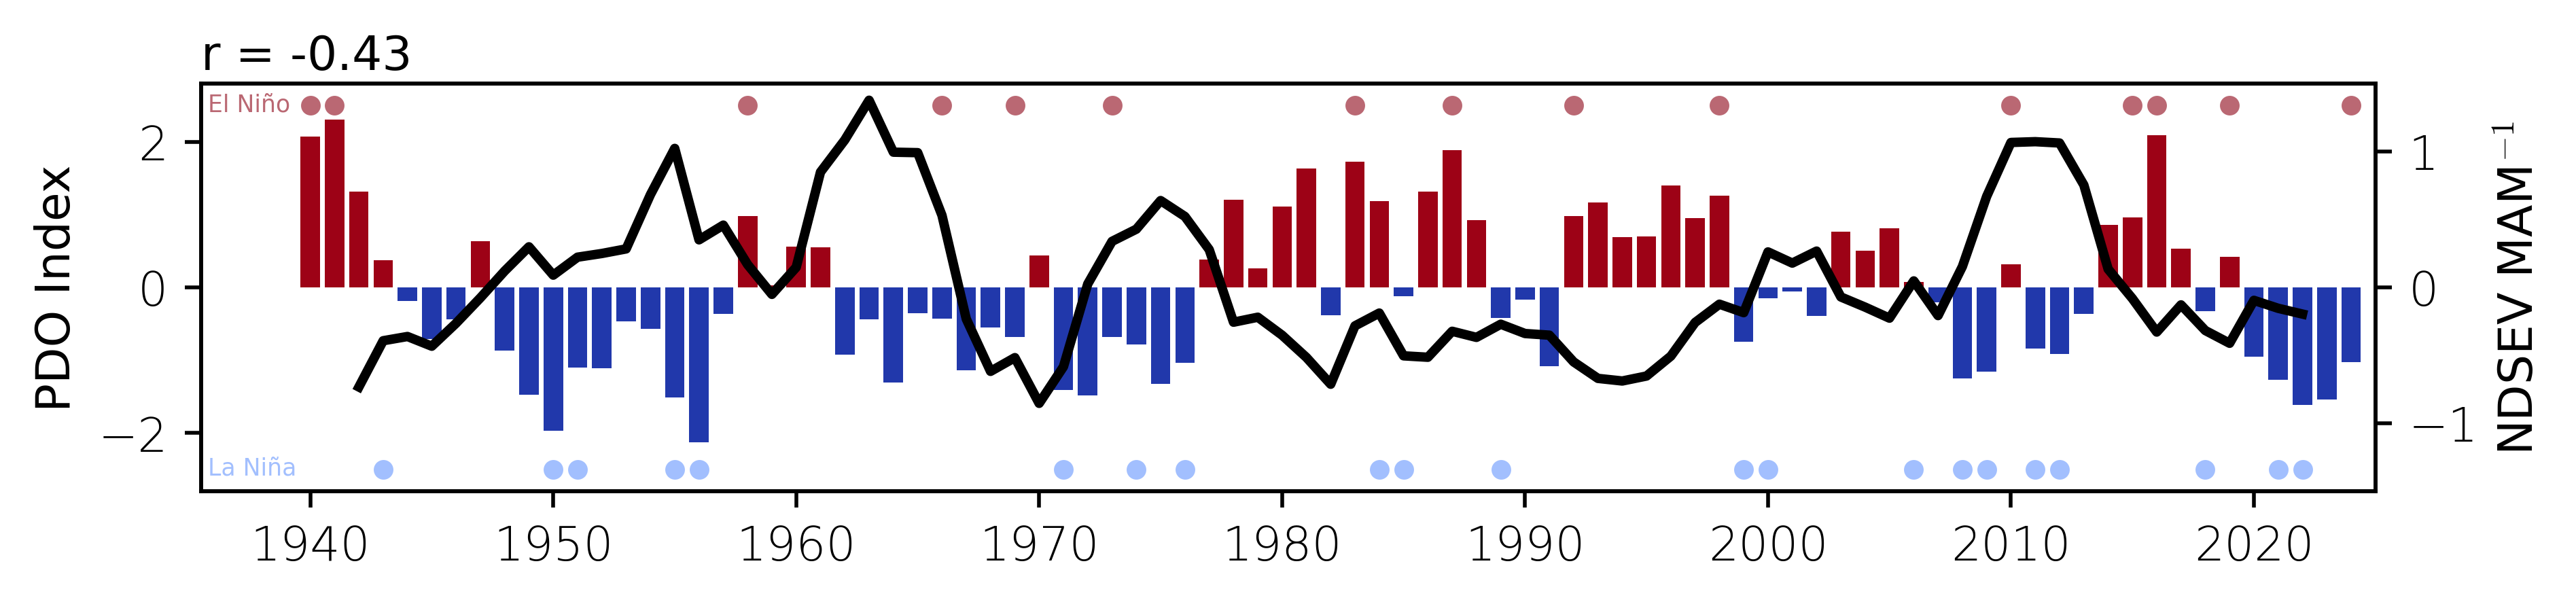

In [37]:
fig, ax = plt.subplots()

# plt.rcParams['text.usetex'] = True

years = np.arange(1940, 2025, 1)

ax.bar(years[pdo_1940_2024_mam > 0], pdo_1940_2024_mam[pdo_1940_2024_mam > 0], color='xkcd:carmine')
ax.bar(years[pdo_1940_2024_mam < 0], pdo_1940_2024_mam[pdo_1940_2024_mam < 0], color='xkcd:sapphire')
ax.set_ylim(-2.8, 2.8)
ax.set_xlim(1935.5, 2025)
ax.set_ylabel('PDO Index', fontsize=10)
ax.scatter(years[nino_34_1940_2024_mam_ann > 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann > 0]*2.5, s=40, color='xkcd:dusky rose', marker='.')
ax.scatter(years[nino_34_1940_2024_mam_ann < 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann < 0]*2.5, s=40, color='xkcd:pastel blue', marker='.')
ax.text(1935.8, 2.42, 'El Niño', color='xkcd:dusky rose', fontweight='normal', fontsize=5)
ax.text(1935.8, -2.57, 'La Niña', color='xkcd:pastel blue', fontweight='normal', fontsize=5)
# ax.set_yticks([-2, -1, 0, 1, 2], fontsize=8)

ax2 = ax.twinx()
ax2.plot(years, ndsev_normal_rolling, color='black', lw=2)
ax2.set_ylim(-1.5, 1.5)
ax2.set_ylabel('NDSEV MAM$^{-1}$', fontsize=10)
# ax2.set_title('ECONUS MAM NDSEV 1940-2024', pad=3)

ax.set_title(f'r = {pearson_r:.2f}', loc='left', pad=3, fontsize=10)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.5, 
                    wspace=0.05, 
                    hspace=0.4)

fig.savefig('/scratch/ivyglade/pdo/paper_figs/saved_pngs/ndsev_timeseries.png', bbox_inches='tight', dpi=500)